## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [4]:
import pandas as pd

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.lower().str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [hello, i, am, your, hot, lil, horny, toy., i,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

> After splitting the emails into tokens (words) and converting everything to lowercase for consistency, I would remove stopwords/common words and elimate noise by removing punctuation, numbers, and special characters. From here I would one-hot-encode the emails' tokens as predictors to prepare for use by models to predict if an email is phishing or not. 

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [5]:
import pickle

with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

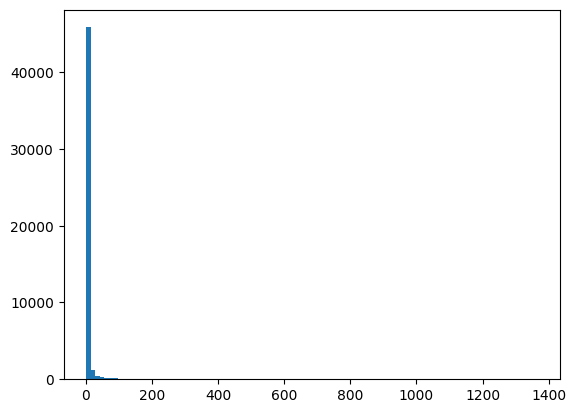

In [7]:
occurences_df = pd.DataFrame(token_freq,columns=['token','count'])
occurences_df['count'].hist(grid=False,bins=100)
occurences_df['count'].describe()

> The histogram is very right skewed. The mode is overwhelmingly 1, meaning most of the tokens appear once and there are some tokens that appear slightly more than once between 2 and ~100. This may make it difficult to make predictions. 

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.


In [14]:
df = pd.read_parquet('Phishing_clean.parquet')

1. Perform an 80/20 train-test split of the data.


In [15]:
from sklearn.model_selection import train_test_split

y = df['Email Type']
X = df.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

y_reg = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = y_reg.predict(X_test)
y_hat_train_0 = y_reg.predict(X_train)
print('training:', r2_score(y_hat_train_0,y_train))
print('testing:', r2_score(y_hat_test_0,y_test))  

training: 0.6144860820476118
testing: -0.000268384328047544


3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [18]:
import numpy as np

coefs = pd.DataFrame({'variable':y_reg.feature_names_in_ , 'value':y_reg.coef_})
coefs['abs'] = np.abs(coefs['value'])
coefs.sort_values('abs',ascending=False)

,variable,value,abs
2223,1997-2002,-1.514772e+13,1.514772e+13
2224,pudge.,1.514772e+13,1.514772e+13
6,2002,1.448712e+13,1.448712e+13
96,000,-1.151892e+13,1.151892e+13
340,2005,-9.766916e+12,9.766916e+12
...,...,...,...
1052,soon,-1.974106e-04,1.974106e-04
319,thing,1.831055e-04,1.831055e-04
254,say,-1.220703e-04,1.220703e-04
512,science,-6.866455e-05,6.866455e-05


> It appears most words that have the largest coefficients in abs value are numbers.

### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

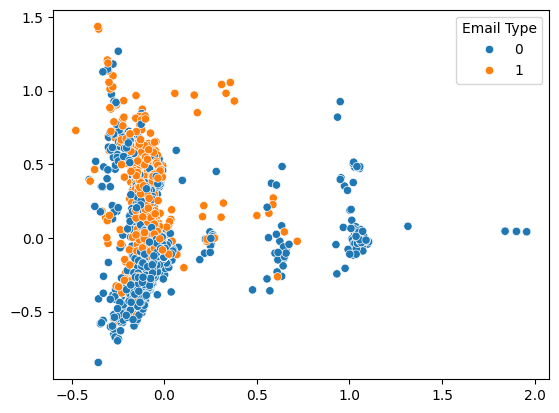

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns

reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

>Looking at the plot where orange represents phishing and blue does not, the orange points have a high second and low first component.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [ ]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Training r^2:', r2_score(y_hat_train,y_train))
print('Testing r^2:', r2_score(y_hat_test,y_test))  

Train r2:  0.692897536096376
Test r2:  0.5873905973217195


> This performed far better than the linear regression, giving an R^2 of 0.587 versus the 0 from the linear regression. 

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

>The advantage of using the principal compenents is reduced multicolinearity due to the components being orthogonal.